In [1]:
%cd ..

/home/ead/iking5/code/StreamLP


In [2]:
import torch
ei, _, ts, y_og = torch.load('mixer-datasets/precalculated/tgbase/raw/wikipedia.pt')
ei = ei.T

/home/ead/iking5/miniconda3/envs/contagion/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [65]:
GRANULARITY=64
SLIDE=1

In [26]:
last_seen = torch.zeros(ei.size())
last_seen_x = torch.full((ei.max()+1,), ts[0])

for i, (src,dst) in enumerate(ei.T): 
    last_seen[0,i] = ts[i] - last_seen_x[src]
    last_seen_x[src] = ts[i]

    last_seen[1,i] = ts[i] - last_seen_x[dst]
    last_seen_x[dst] = ts[i]

del last_seen_x

In [77]:
# Processing 
last_seen_proccessed = torch.log(last_seen+1e-8).ceil()
if last_seen_proccessed.min() < 0: 
    last_seen_proccessed += - last_seen_proccessed.min()
last_seen_proccessed = last_seen_proccessed.long()

#last_seen_proccessed = last_seen_proccessed.long().split(GRANULARITY, dim=1)
idx = torch.arange(last_seen_proccessed.size(1)).unfold(0, GRANULARITY, SLIDE)
y = y_og[idx].sum(dim=1)
last_seen_proccessed = [last_seen_proccessed[:, i] for i in idx]
eis = [ei[:, i] for i in idx]

In [79]:
from models.assortative_mixing import CategoricalAMC as AMC 
from tqdm import tqdm 

coefs = []
for e in tqdm(last_seen_proccessed):
    amc = AMC(n_classes=128)
    coefs.append(amc.add_edges(e))

coefs = torch.tensor(coefs)

  5%|▌         | 8561/157411 [00:03<01:03, 2351.19it/s]


KeyboardInterrupt: 

/home/ead/iking5/miniconda3/envs/contagion/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


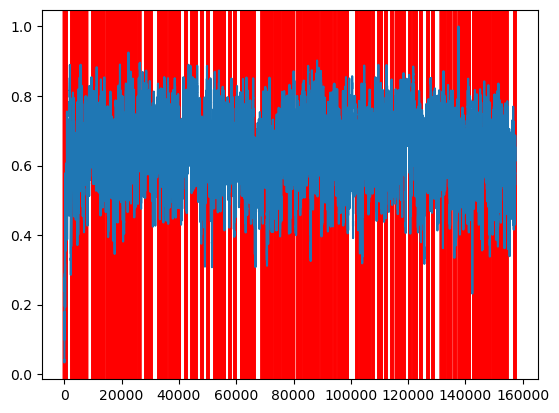

In [76]:
import matplotlib.pyplot as plt 

[plt.axvline(x=i, color='r') for i in y.nonzero()]
plt.plot(torch.arange(coefs.size(0)), coefs)
plt.show()